# Noise Plots

Lukas Graz  
August 19, 2025

## Setup + Preprocessing

In [ ]:
suppressPackageStartupMessages({
  library(dplyr)
  library(ggplot2)
  library(egg)
  library(kernlab)
  library(mgcv)  # for GAM models - smoothing
  library(gridExtra)  # for combining plots
  library(tidyr)  # for pivoting data
  library(tune) # square plots
})

theme_set(theme_minimal())


options(digits = 3)
options(warn=-1)
source("R/data_prep.R")


Number of matches per filter criteria (not disjoint)
  Headphone  PRS_all_NA    Distance Activity_NA    Duration  HMNoise_NA 
        303         226         221         102          96          96 
JourneyTime 
         20 
Keep  1494 of 2206 observations

Imputing PRS_orig_vars

In [ ]:
D$RL_NDVI     <- pmax(0, D$RL_NDVI)
D_trn$RL_NDVI <- pmax(0, D_trn$RL_NDVI)
D_tst$RL_NDVI <- pmax(0, D_tst$RL_NDVI)


## Plots for soundscape description

In [ ]:

# Create Plot 1: Dominating Sounds ---------------
D_long <- D |>
  pivot_longer(
    cols = starts_with("LDOMAUD"),
    names_to = "Sound_Type",
    values_to = "Value"
  )
# rename the sound types for better readability
D_long$Sound_Type <- recode(D_long$Sound_Type,
  LDOMAUD1 = "Nature sounds",
  LDOMAUD2 = "Human sounds",
  LDOMAUD3 = "Traffic sounds",
  LDOMAUD4 = "Other technical noises"
)
p_dominating_sound <- ggplot(D_long, aes(x = RL_NOISE, y = Value, color = Sound_Type)) +
  geom_smooth(method = "gam", se = TRUE, alpha = 0.3, size = 1.2, formula = y ~ s(x, bs = "cs")) +
  # ylim(1, 5) +
  ylab("Response [1-5]") +
  labs(title = "a. Sound type")


# Create Plot 2: Soundscape Attributes ---------------
D_long <- D |>
  pivot_longer(
    cols = starts_with("LSOUNDS"),
    names_to = "Attribute",
    values_to = "Value"
  )
# rename the attributes for better readability
D_long$Attribute <- recode(D_long$Attribute,
  LSOUNDS1 = "Pleasant",
  LSOUNDS2 = "Chaotic",
  LSOUNDS3 = "Vibrant",
  LSOUNDS4 = "Uneventful",
  LSOUNDS5 = "Tranquil",
  LSOUNDS6 = "Bothering",
  LSOUNDS7 = "Eventful",
  LSOUNDS8 = "Monotone",
  LSOUNDS9 = "Loud"
)
p_soundscate_attr <- ggplot(D_long, aes(x = RL_NOISE, y = Value, color = Attribute)) +
  geom_smooth(method = "gam", se = TRUE, alpha = 0.3, size = 1.2, formula = y ~ s(x, bs = "cs")) +
  # ylim(1, 5) +
  scale_color_brewer(palette = "Set1") +
  ylab("Response [1-5]") +
  labs(title = "b. Soundscape assessment")



# NOISE ANNOYANCE
# For the noise annoyance variables, we need to handle the character values
# Convert character annoyance values to numeric
convert_annoyance <- function(x) {
  case_when(
    x == "00" ~ 0,
    x == "01" ~ 1,
    x == "02" ~ 2,
    x == "03" ~ 3,
    x == "04" ~ 4,
    x == "05" ~ 5,
    x == "06" ~ 6,
    x == "07" ~ 7,
    x == "08" ~ 8,
    x == "09" ~ 9,
    x == "10" ~ 10,
    x == "No annoyance" ~ 0,
    x == "Response scale mid-point" ~ 5,
    x == "Very annoying" ~ 10,
    TRUE ~ as.numeric(x)
  )
}
# Create a temporary data frame with converted values for noise annoyance
D_temp <- D |>
  mutate(
    LSANNOY1_num = convert_annoyance(LSANNOY1),
    LSANNOY2_num = convert_annoyance(LSANNOY2),
    LSANNOY3_num = convert_annoyance(LSANNOY3),
    LSANNOY4_num = convert_annoyance(LSANNOY4),
    LSANNOY5_num = convert_annoyance(LSANNOY5),
    LSANNOY6_num = convert_annoyance(LSANNOY6),
    LSANNOY7_num = convert_annoyance(LSANNOY7)
  )

vars_tmp <- c("LSANNOY1_num", "LSANNOY2_num", 
  "LSANNOY3_num", "LSANNOY4_num", "LSANNOY5_num", "LSANNOY6_num", "LSANNOY7_num")
D_long_annoyance <- pivot_longer(
  D_temp,
  cols = all_of(vars_tmp),
  names_to = "Annoyance",
  values_to = "Value"
)
# rename
D_long_annoyance$Annoyance <- recode(D_long_annoyance$Annoyance,
  LSANNOY1_num = "Road Traffic",
  LSANNOY2_num = "Public Transport",
  LSANNOY3_num = "Train",
  LSANNOY4_num = "Plane",
  LSANNOY5_num = "Freetime",
  LSANNOY6_num = "Music of others",
  LSANNOY7_num = "Works"
)
D_long_annoyance$Annoyance <- factor(D_long_annoyance$Annoyance, 
  levels = c("Road Traffic", "Public Transport", 
             "Train", "Plane", "Freetime", "Music of others", "Works")
)
p_noise_annoy <- ggplot(D_long_annoyance, aes(x = RL_NOISE, y = Value, color = Annoyance)) +
  geom_smooth(method = "gam", se = TRUE, alpha = 0.3, size = 1.2, formula = y ~ s(x, bs = "cs")) +
  # ylim(0, 10) +
  ylab("Response [0-10]") + 
  labs(title = "c. Noise annoyance")


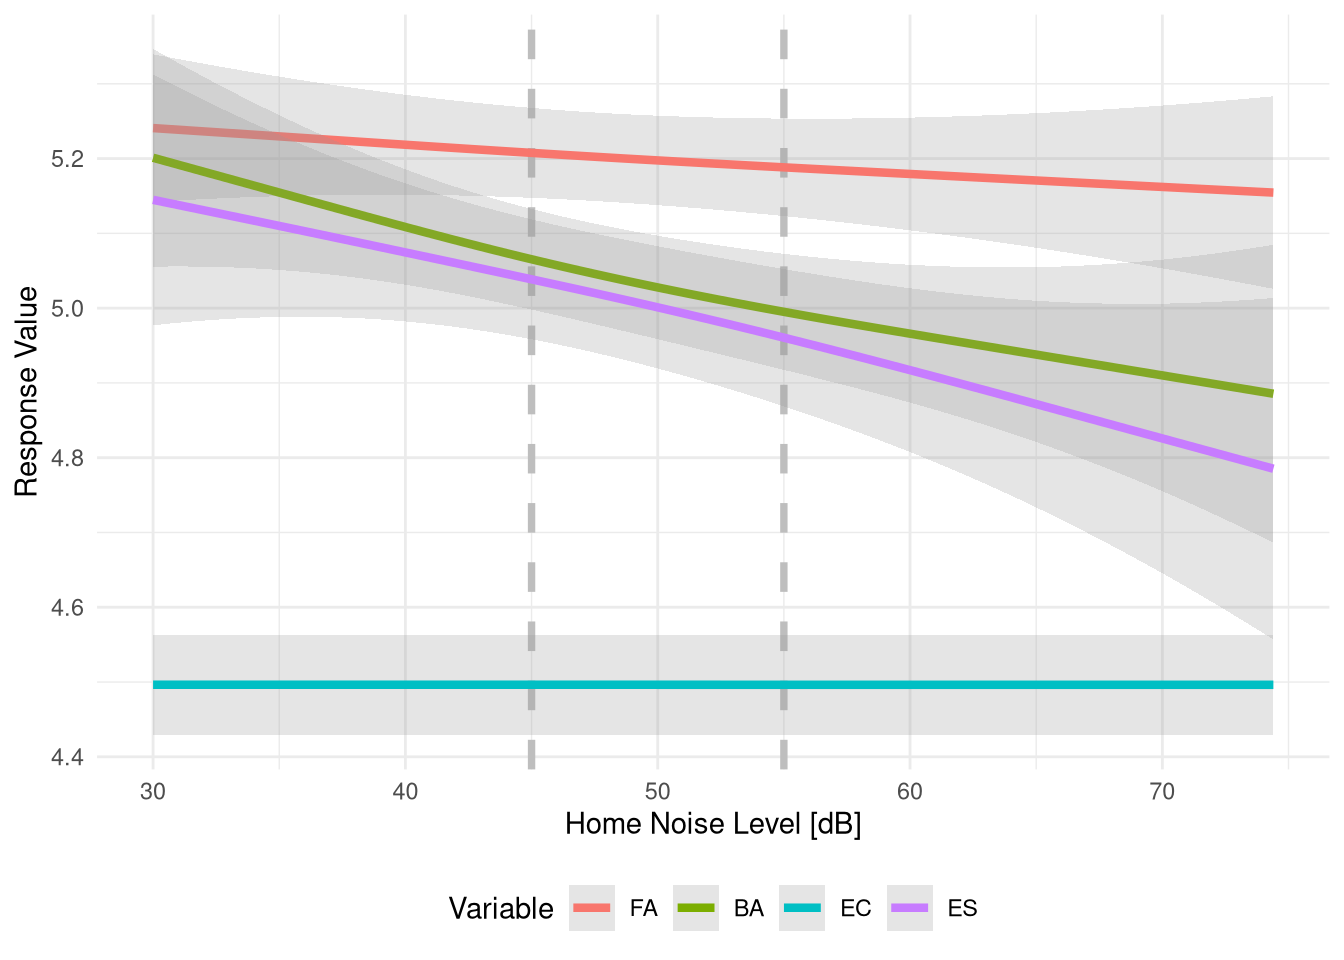

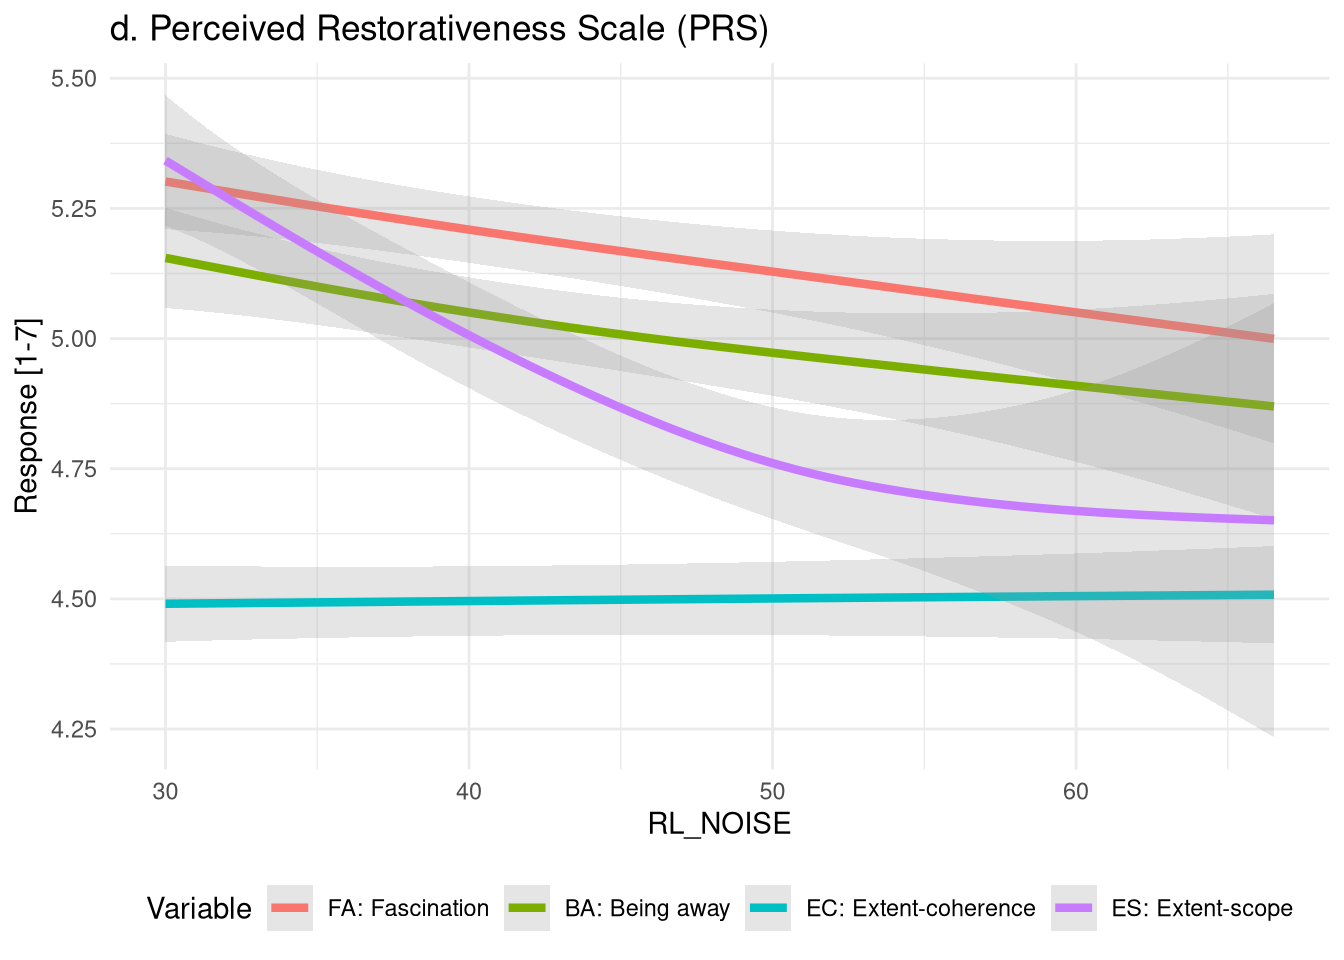

In [ ]:

# plot RL_NOISE vs FA, BA, EC, ES, with a smoothing line each (one plot per y)
# create first dataset that only contains relevant variables for the folowing plots
D.plot <- D[, c("HM_NOISE", "RL_NOISE", "HM_NDVI", "RL_NDVI", "FA", "BA", "EC", "ES")]
D.plot <- pivot_longer(D.plot, 
                      cols = c("FA", "BA", "EC", "ES"), 
                      names_to = "Variable", 
                      values_to = "Value")
# order the Variable factor levels
D.plot$Variable <- factor(D.plot$Variable, 
                          levels = c("FA", "BA", "EC", "ES"))

# plot RL_NOISE vs FA, BA, EC, ES, with a smoothing line each (one plot per y)
ggplot(D.plot, aes(x = HM_NOISE, y = Value, color = Variable)) +
  geom_vline(xintercept = c(45, 55), linetype = "dashed", color = "gray", linewidth = 1.3) +
  geom_smooth(method = "gam", se = TRUE, alpha = 0.25, linewidth = 1.5, formula = y ~ s(x, bs = "cs")) +
  labs(
    x = "Home Noise Level [dB]",
    y = "Response Value",
    color = "Variable"
  ) +
  theme(legend.position = "bottom")


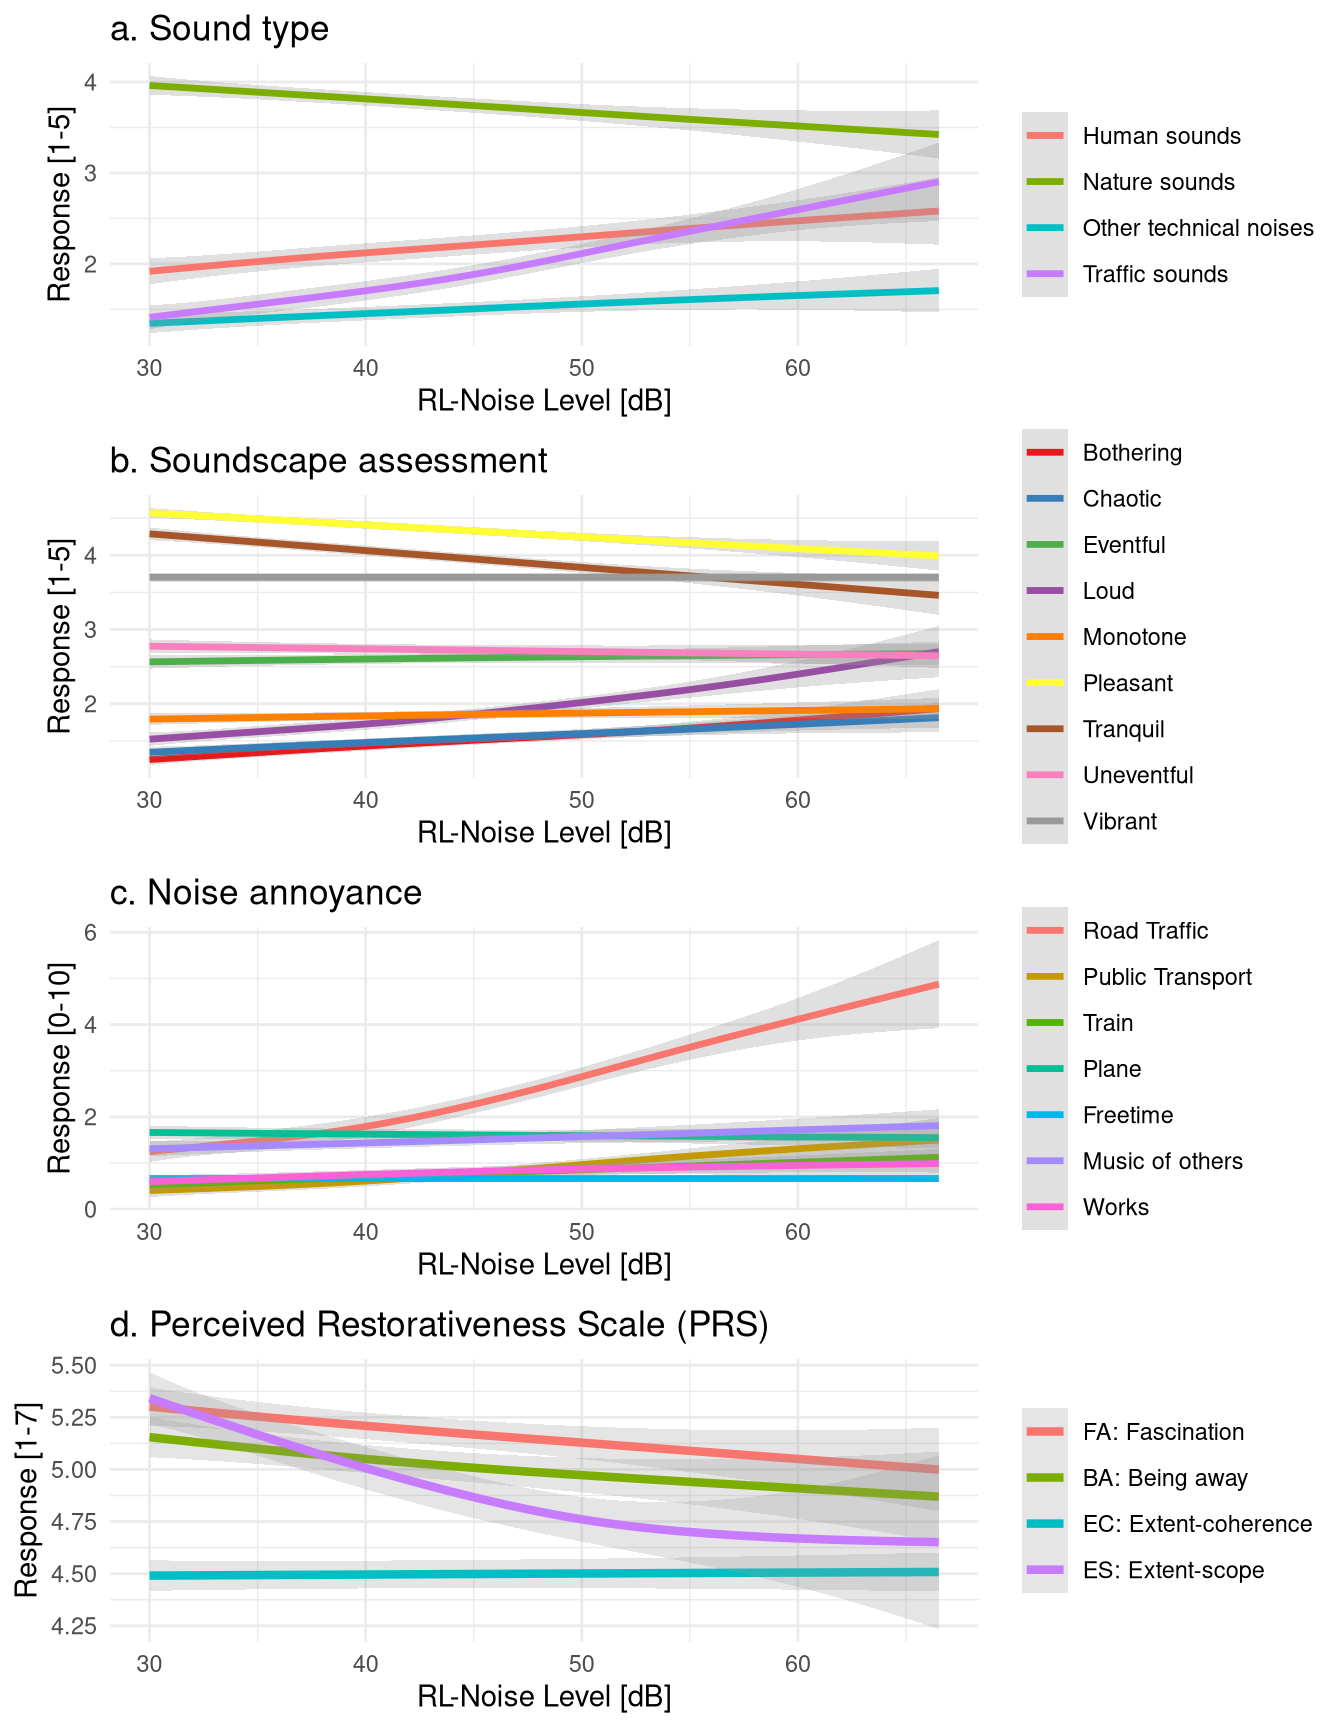

In [ ]:
add_generic <- list(
  # xlim(30, 70),
  xlab("RL-Noise Level [dB]"), 
  theme(legend.title = element_blank())
  )

# Combine all plots vertically
combined_plot <- suppressWarnings({
  ggarrange(
    p_dominating_sound + add_generic, 
    p_soundscate_attr + add_generic,
    p_noise_annoy + add_generic,
    p_RLNOISE_PRS + add_generic,
    ncol = 1)
})
# ggsave("cache/combinded_plot.pdf", combined_plot, height=8, width = 7)

# combined_plot


## RL ~ HM — for NOISE and NDVI

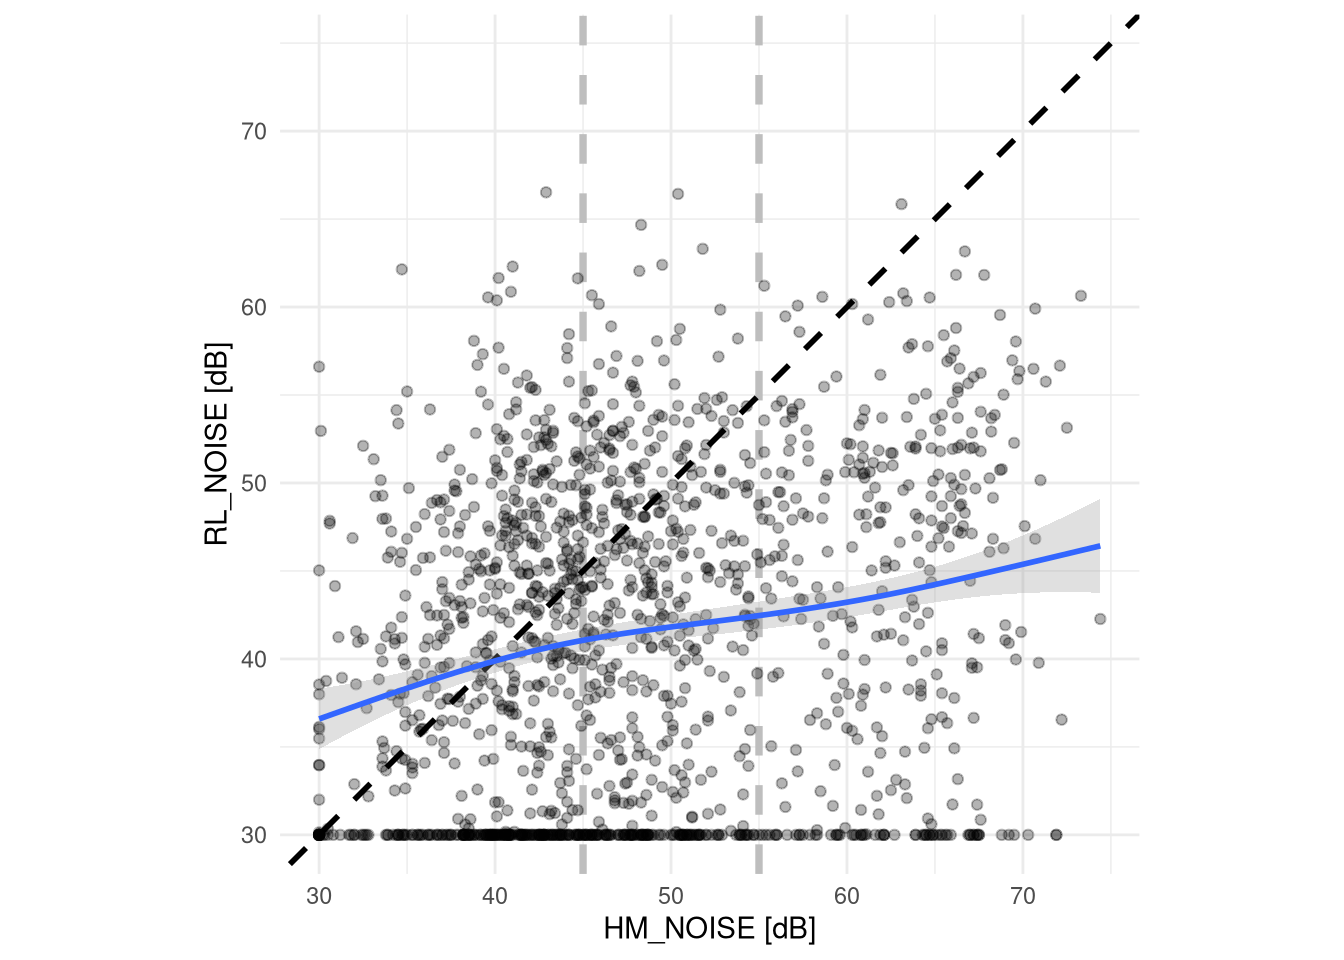

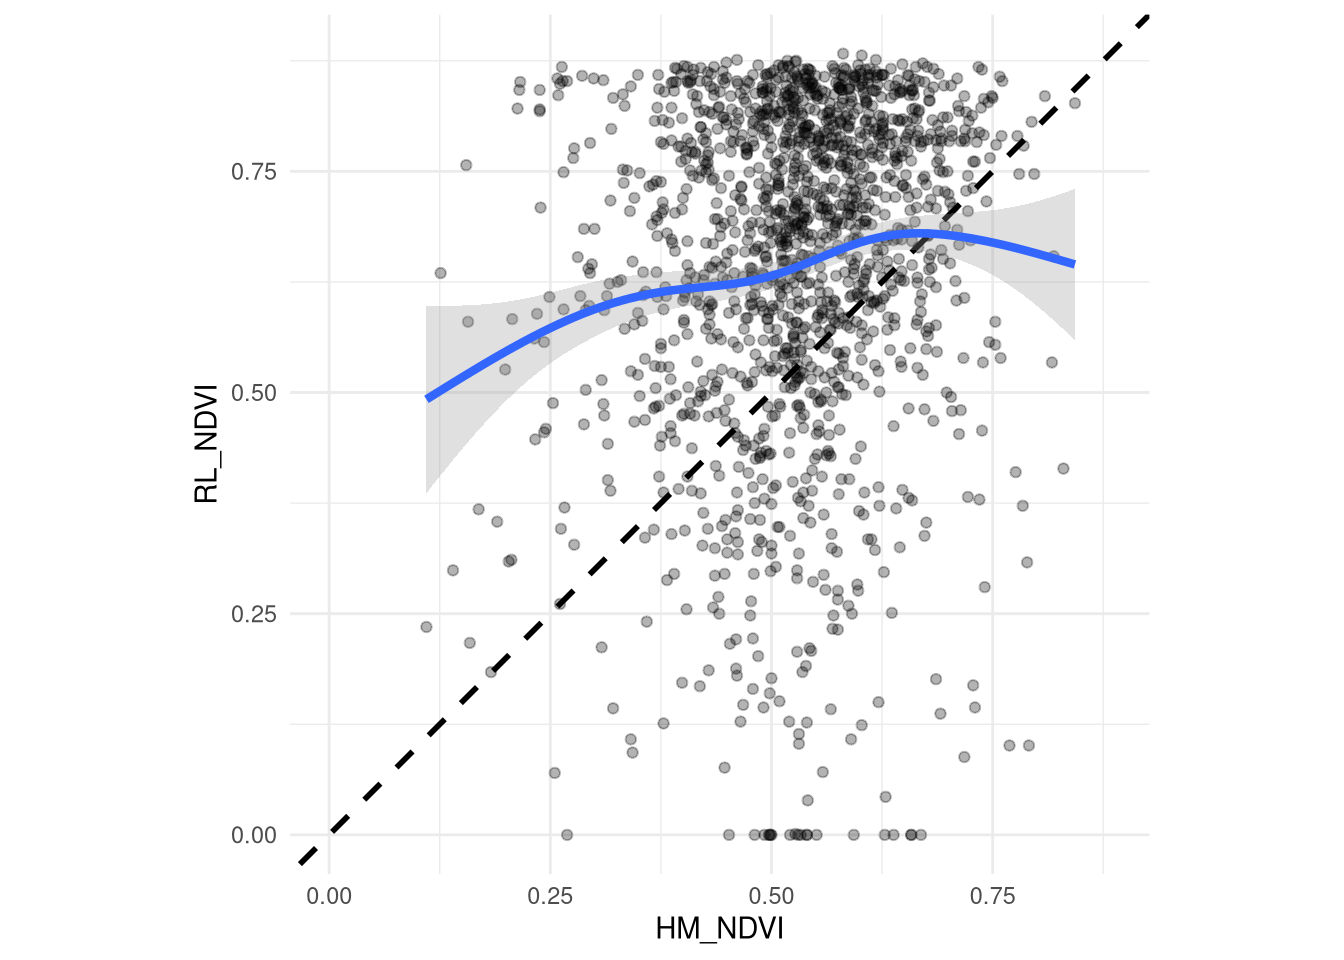

In [ ]:

# plot RL_NOISE vs HM_NOISE with a smoothing linec
ggplot(D, aes(x = HM_NOISE, y = RL_NOISE)) +
  geom_vline(xintercept = c(45, 55), linetype = "dashed", color = "gray", linewidth = 1.3) +
  geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "black", linewidth = 1) +
  geom_point(alpha = 0.3) +
  geom_smooth(method = "gam", se = TRUE, alpha = 0.3, formula = y ~ s(x, bs = "cs")) +
  labs(
    x = "HM_NOISE [dB]",
    y = "RL_NOISE [dB]"
  ) + 
  coord_obs_pred() # for aspect ratio 1:1


## LNOISE ~ HM_NOISE or RL_NOISE

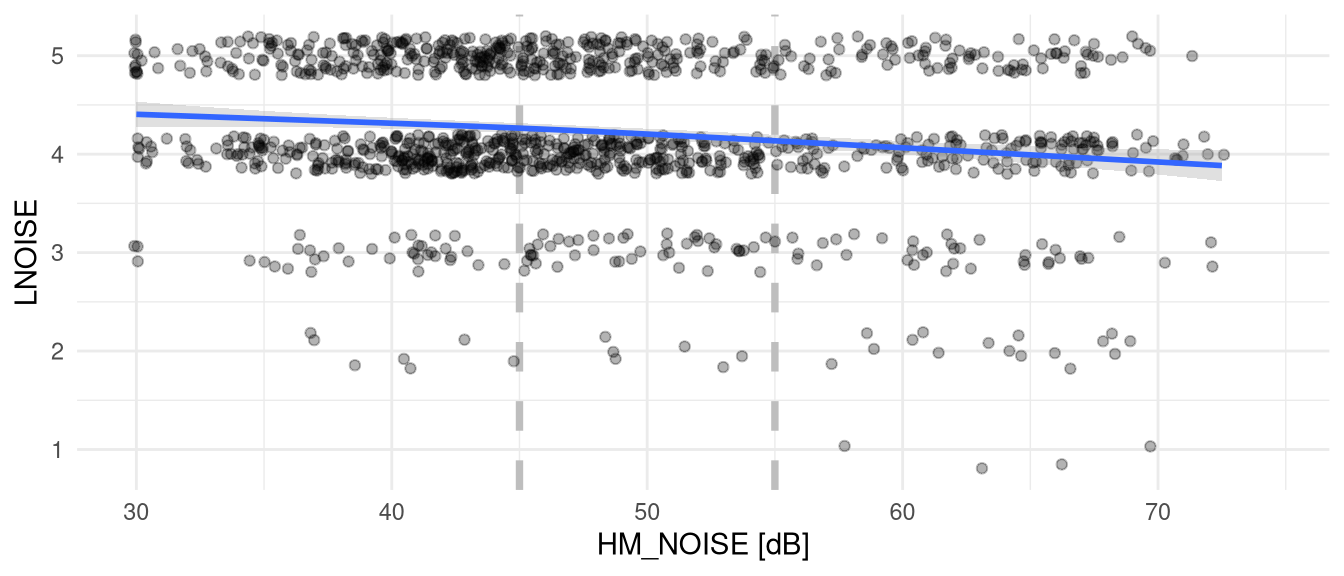

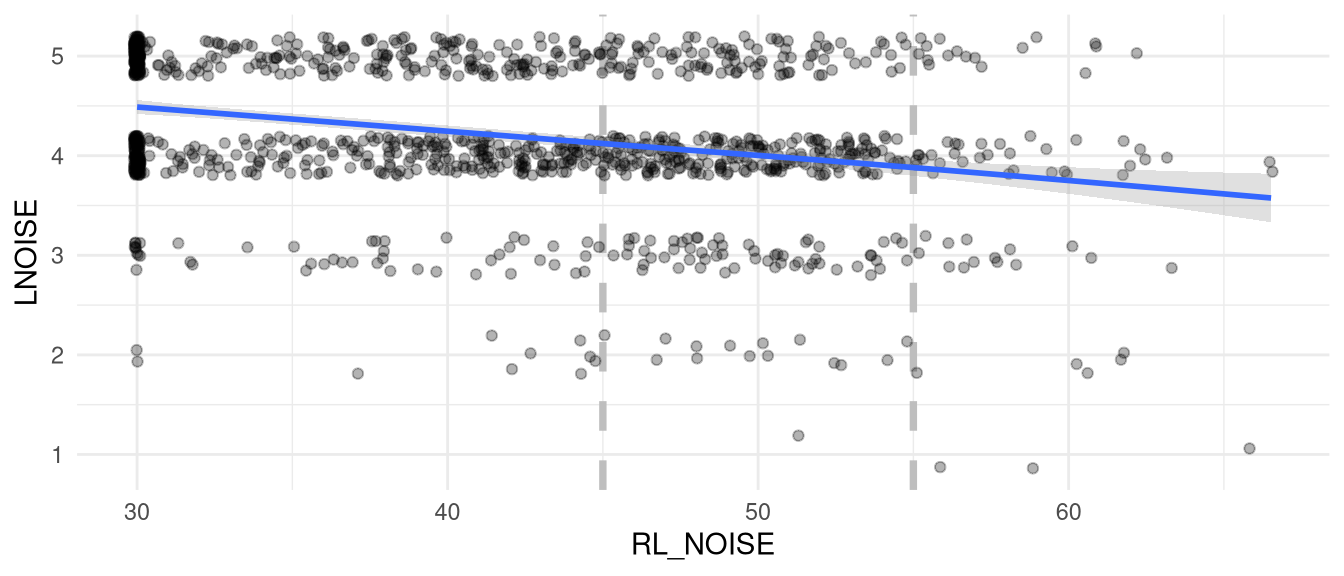

In [ ]:

# plot HM_NOISE vs LNOISE with a smooth line (and small jitter sd=0.2)
ggplot(D, aes(x = HM_NOISE, y = LNOISE)) +
  geom_vline(xintercept = c(45, 55), linetype = "dashed", color = "gray", linewidth = 1.3) +
  geom_jitter(width = 0.1, height = 0.2, alpha = 0.3) +
  geom_smooth(method = "gam", se = TRUE, alpha = 0.3, formula = y ~ s(x, bs = "cs")) +
  labs(
    x = "HM_NOISE [dB]",
    y = "LNOISE"
  )


### ADD proportions

In [ ]:

# Define at cutof 45 and 55 dB
D$HM_NOISELVL <- cut(D$HM_NOISE, breaks = c(-Inf, 45, 55, Inf), 
                     labels = c("Low", "Medium", "High"))
D$RL_NOISELVL <- cut(D$RL_NOISE, breaks = c(-Inf, 45, 55, Inf), 
                     labels = c("Low", "Medium", "High"))
# Get marginal percentage (how many in which LNOISE lvl) for each level of HM_NOISELVL/RL_NOISELVL
HM_tab <- xtabs(~ HM_NOISELVL + LNOISE, D)
RL_tab <- xtabs(~ RL_NOISELVL + LNOISE, D)

HM_tab_prop <- (100 * prop.table(HM_tab, margin = 1)) |> round(1) 
RL_tab_prop <- (100 * prop.table(RL_tab, margin = 1)) |> round(1)

# HM.df <- as.data.frame(HM_tab)
# RL.df <- as.data.frame(RL_tab)

HM_prop.df <- as.data.frame(HM_tab_prop)
RL_prop.df <- as.data.frame(RL_tab_prop)

# add X, with the dict according to NOISELVL Low = 38, Medium = 48, High = 58
dict <- c("Low" = 37.5, "Medium" = 50, "High" = 62.5)
HM_prop.df$HM_NOISELVL <- dict[HM_prop.df$HM_NOISELVL]
RL_prop.df$RL_NOISELVL <- dict[RL_prop.df$RL_NOISELVL]

HM_prop.df$LNOISE <- as.numeric(HM_prop.df$LNOISE)
RL_prop.df$LNOISE <- as.numeric(RL_prop.df$LNOISE)


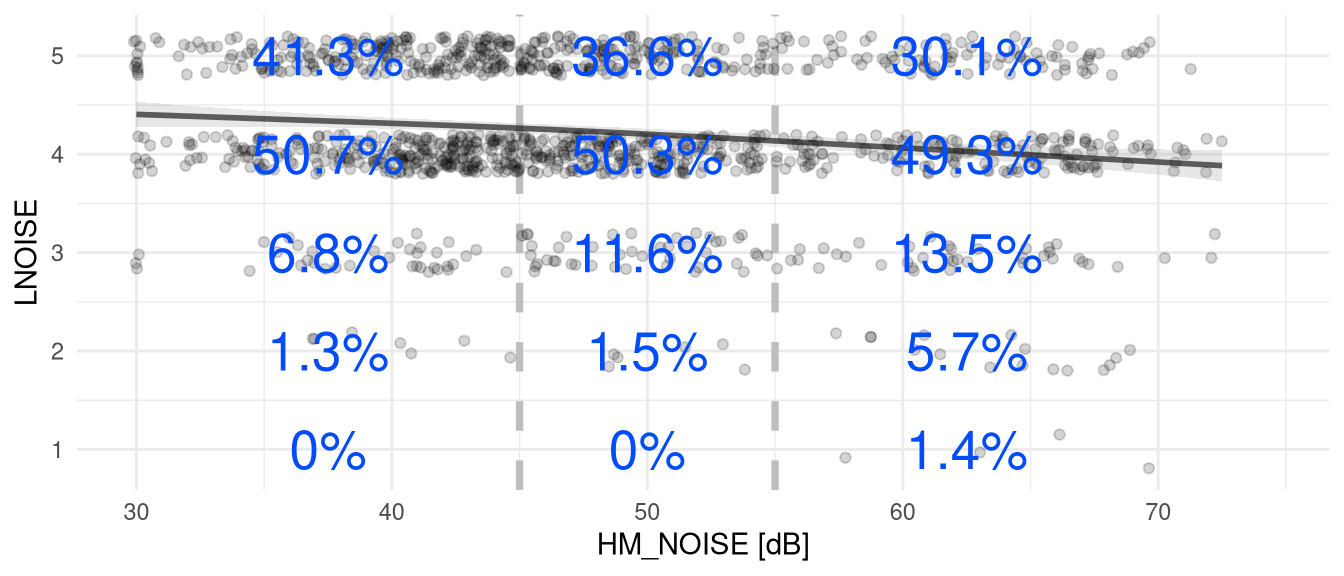

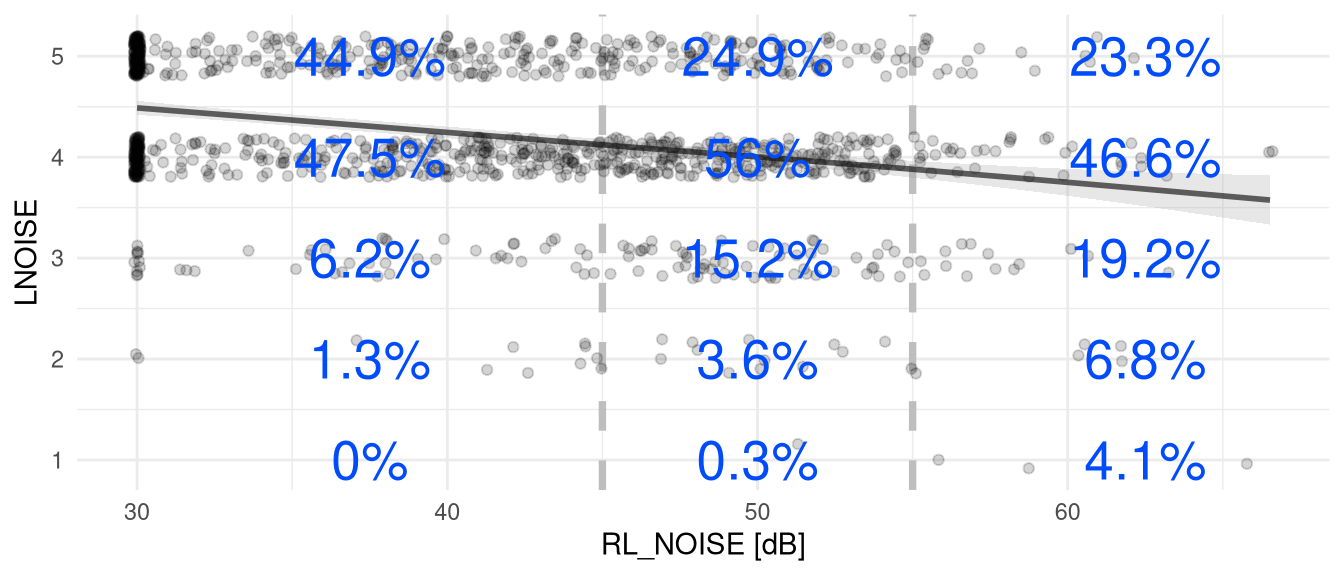

In [ ]:

# repeat plots, but add the marginal percentages as text
ggplot(D, aes(x = HM_NOISE, y = LNOISE)) +
  geom_vline(xintercept = c(45, 55), linetype = "dashed", color = "gray", linewidth = 1.3) +
  geom_jitter(width = 0.1, height = 0.2, alpha = 0.17) +
  geom_smooth(method = "gam", se = TRUE, color = "#0000009a", alpha = 0.23, formula = y ~ s(x, bs = "cs")) +
  labs(
    x = "HM_NOISE [dB]",
    y = "LNOISE"
  ) +
  geom_text(data = HM_prop.df, aes(x = HM_NOISELVL, y = LNOISE, 
                                    label = paste0(Freq, "%")), size = 7, col = "#004bfbff")


In [ ]:
HM_tab_prop


           LNOISE
HM_NOISELVL    1    2    3    4    5
     Low     0.0  1.3  6.8 50.7 41.3
     Medium  0.0  1.5 11.6 50.3 36.6
     High    1.4  5.7 13.5 49.3 30.1

           LNOISE
RL_NOISELVL    1    2    3    4    5
     Low     0.0  1.3  6.2 47.5 44.9
     Medium  0.3  3.6 15.2 56.0 24.9
     High    4.1  6.8 19.2 46.6 23.3